### Projeto de previsão de ocorrência de sintomas ###


O início dos sintomas em pacientes com fibrose pulmonar é desconhecido. No entanto, determinar este início é crucial para compreender a progressão da doença, pois você pode ajudar a identificar se a fibrose pulmonar é progressiva ou se você se encontra em um estádio avançado. Uma das medidas mais comuns em pacientes com doenças pulmonares crônicas é a avaliação anual da capacidade vital forçada (CVF), que fornece informações importantes sobre a progressão da doença, permitindo determinar se o paciente está melhorando ou melhorando.

O objetivo deste projeto foi desenvolver um modelo de regressão de efeitos mistos capaz de prever o início dos sintomas em pacientes com fibrose pulmonar. Para isso, utilizamos a CVF como referência para o declínio da função pulmonar ao longo do tempo. A partir desta medida, buscamos estimar em que momento um paciente tinha uma CVF inicial de 100 (valor considerado normal) para poder determinar o tempo aproximado em que os sintomas começaram. Este momento foi definido como tempo zero no dia em que se realizou a biópsia pulmonar, o que permitiu calcular o tempo transcorrido até que o paciente alcançasse uma CVF de 100.

Esta abordagem não oferece apenas uma estimativa do início dos sintomas, embora também contribua para a compreensão da dinâmica da doença, o que pode ser útil para melhorar o manejo clínico e as decisões terapêuticas em pacientes com fibrose pulmonar.


A fórmula matemática do modelo de regressão de efeitos mistos com a parte aleatória incluída pode ser expressa como:

***FVC
𝑖
𝑗 
= 𝛽0
+
𝛽1
⋅
MESES
𝑖
𝑗
+
𝑢
0
𝑖
+
𝜖
𝑖
𝑗
FVC 
ij
​
 =β 
0
​
 +β 
1
​
 ⋅MESES 
ij
​
 +u 
0i
​
 +ϵ 
ij
​***
 
Componentes:

***Parte fixa:***

𝛽0
:Intercepto global do modelo (valor médio inicial de FVC para todos os pacientes quando MESES = 0).

𝛽1
:Inclinação global que representa a relação entre MESES e FVC.

***Parte aleatória:***

𝑢0𝑖​
:Efeito aleatório do paciente 𝑖, que captura as diferenças individuais no intercepto.

𝜖𝑖𝑗​
:Erro residual associado à observação 𝑗j dentro do paciente 𝑖

***Índices:***

𝑖
:Identifica o paciente (grupo).

𝑗
:Identifica a medição específica dentro do paciente 𝑖

Esse modelo permite que cada paciente tenha seu próprio intercepto (𝛽0 + 𝑢0𝑖), mas compartilha a mesma inclinação global (b1) para a relação entre MESES e FVC. entre MESES e FVC.

In [100]:
#Bibliotecas a utilizar 
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt

***Etapa 1: Carregar o Arquivo e verificar os dados***   

In [61]:
# Carregar o arquivo 
DPI = 'C:/Users/Herrera/Documents/Python excels/TABELADPI.xlsx'
df = pd.read_excel(DPI)
df.columns = df.columns.str.strip() #Para limpar espaços dos nomes das colunas
# Imprimir as primeiras 5 linhas  
print(df.head())  


   PACIENTE  FVC1  MESESFVC1  FVC2  MESESFVC2  FVC3  MESESFVC3  FVC4  \
0         2  48.0        161  35.0      172.0  38.0      205.0  38.0   
1         3  39.0        122  38.0      130.0  35.0      145.0  36.0   
2         4  54.0        132  44.7      141.0  48.0      152.0   NaN   
3         7  57.0         86  57.0       95.0  54.0      107.0  56.0   
4         8  79.0         46  75.0       60.0  63.0        NaN  61.0   

   MESESFVC4  
0      210.0  
1      152.0  
2        NaN  
3      113.0  
4       69.0  


In [63]:
#Imprimir os nomes das colunas
print("Nomes e tipos de colunas")
print(df.columns)
print(type(df.columns))

# Mostrar os tipos de dados das colunas
print("Tipos de dados das colunas:")
print(df.dtypes)

Nomes e tipos de colunas
Index(['PACIENTE', 'FVC1', 'MESESFVC1', 'FVC2', 'MESESFVC2', 'FVC3',
       'MESESFVC3', 'FVC4', 'MESESFVC4'],
      dtype='object')
<class 'pandas.core.indexes.base.Index'>
Tipos de dados das colunas:
PACIENTE       int64
FVC1         float64
MESESFVC1      int64
FVC2         float64
MESESFVC2    float64
FVC3         float64
MESESFVC3    float64
FVC4         float64
MESESFVC4    float64
dtype: object


***Etapa 2: Imputar dados Faltantes*** 

In [65]:
df['MESESFVC1'] = df['MESESFVC1'].astype(float)

imputer = SimpleImputer(strategy='mean')  #  Estrategia da media para imputar
# Imputar os valores de FVC e Meses para as colunas 
df[['FVC2', 'MESESFVC2', 'FVC3', 'MESESFVC3', 'FVC4', 'MESESFVC4']] = imputer.fit_transform(df[['FVC2', 'MESESFVC2', 'FVC3', 'MESESFVC3','FVC4', 'MESESFVC4']])

print("\nVerificação de dados depois a imputação:")
print(df[['FVC2', 'MESESFVC2', 'FVC3', 'MESESFVC3', 'FVC4', 'MESESFVC4']].isnull().sum())

# Vista previa de los datos imputados
print("\nVisualização do DataFrame:")
print(df.head())


Verificação de dados depois a imputação:
FVC2         0
MESESFVC2    0
FVC3         0
MESESFVC3    0
FVC4         0
MESESFVC4    0
dtype: int64

Visualização do DataFrame:
   PACIENTE  FVC1  MESESFVC1  FVC2  MESESFVC2  FVC3   MESESFVC3       FVC4  \
0         2  48.0      161.0  35.0      172.0  38.0  205.000000  38.000000   
1         3  39.0      122.0  38.0      130.0  35.0  145.000000  36.000000   
2         4  54.0      132.0  44.7      141.0  48.0  152.000000  66.316875   
3         7  57.0       86.0  57.0       95.0  54.0  107.000000  56.000000   
4         8  79.0       46.0  75.0       60.0  63.0   26.930233  61.000000   

   MESESFVC4  
0     210.00  
1     152.00  
2      36.25  
3     113.00  
4      69.00  


***Etapa 3: Modificar o formato do conjunto de dados***  

In [67]:
# Reformatamos os dados para ter uma linha por medição de FVC
fvc_colunas = ['FVC1', 'FVC2',  'FVC3',  'FVC4']
meses_colunas = ['MESESFVC1', 'MESESFVC2', 'MESESFVC3', 'MESESFVC4']

# convertemos os dados para que cada medição de FVC tenha sua própria linha
treino_df = pd.melt(df,
                     id_vars=['PACIENTE'],  # Colunas de identificação do paciente
                     value_vars=fvc_colunas,  # Colunas de medidas de FVC
                     var_name='Medição',  # Nome da coluna indicando se é FVC1, FVC2...
                     value_name='FVC')  # Valor de medição de FVC

# Ahora añadimos los valores de tiempo para cada medición
treino_df['MESES'] = pd.melt(df,
                               id_vars=['PACIENTE'],
                               value_vars=meses_colunas,
                               value_name='MESES')['MESES']


# Imprimir algumas filhas dos dados para confirmar conversão 
print(treino_df.iloc[40:61])


    PACIENTE Medição         FVC       MESES
40        61    FVC1   56.000000    2.000000
41        62    FVC1   97.000000   14.000000
42        63    FVC1   82.000000   -2.000000
43        64    FVC1   78.000000   -3.000000
44        65    FVC1   60.000000  -22.000000
45        66    FVC1   94.000000  -23.000000
46        68    FVC1   70.000000  -71.000000
47        71    FVC1   76.000000   -5.000000
48        72    FVC1   67.000000    0.000000
49        74    FVC1   71.000000  -32.000000
50        75    FVC1   85.000000  -12.000000
51        76    FVC1  104.000000  -35.000000
52        77    FVC1   48.000000   -1.000000
53        78    FVC1   72.330000  -23.000000
54        79    FVC1   33.000000   -6.000000
55         2    FVC2   35.000000  172.000000
56         3    FVC2   38.000000  130.000000
57         4    FVC2   44.700000  141.000000
58         7    FVC2   57.000000   95.000000
59         8    FVC2   75.000000   60.000000
60         9    FVC2   63.890204   15.795918


***Etapa 4: validação cruzada***

In [77]:
# Inicializando a validação cruzada com 5 folds
n_splits = 5
kf = GroupKFold(n_splits=n_splits)

# Lista para armazenar os resultados de cada fold
resultados = []

# Realizando a validação cruzada hierárquica
for train_index, val_index in kf.split(treino_df, groups=treino_df['PACIENTE']):
    # Dividindo os dados entre treino e validação para este fold
    treino_fold = treino_df.iloc[train_index]
    val_fold = treino_df.iloc[val_index]
    
    # Ajustando o modelo com os dados de treino
    model = mixedlm("FVC ~ MESES", treino_fold, groups=treino_fold["PACIENTE"])
    result = model.fit()
    
    # Avaliando o modelo com os dados de validação (usando os efeitos fixos)
    intercepto = result.fe_params['Intercept']
    pendiente = result.fe_params['MESES']
    
    # Predizendo o FVC para os dados de validação
    val_fold = val_fold.copy()  # Criar uma cópia explícita
    val_fold['FVC_pred'] = intercepto + pendiente * val_fold['MESES']
    
    # Armazenando os resultados deste fold
    resultados.append(val_fold)

# Concatenando os resultados de todas as iterações
resultado_final = pd.concat(resultados)

# Exibindo os resultados finais de todas as previsões
print(resultado_final[['PACIENTE', 'MESES', 'FVC', 'FVC_pred']])

     PACIENTE   MESES        FVC   FVC_pred
1           3  122.00  39.000000  55.710886
6          10   24.00  41.000000  66.804578
11         16   10.00  58.000000  68.389391
16         23  -12.00  75.000000  70.879812
21         32  -21.00  68.000000  71.898620
..        ...     ...        ...        ...
198        50   45.00  65.000000  64.544050
203        57   -3.00  43.000000  68.489534
206        62   36.25  66.316875  65.263279
208        64   36.25  66.316875  65.263279
213        72   36.25  66.316875  65.263279

[220 rows x 4 columns]


***Etapa 5: Ajustando o modelo***

In [92]:
model2 = mixedlm("FVC ~ MESES", treino_df, groups=treino_df["PACIENTE"])
result2 = model2.fit()
print (result2.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: FVC      
No. Observations: 220     Method:             REML     
No. Groups:       55      Scale:              73.1083  
Min. group size:  4       Log-Likelihood:     -857.2108
Max. group size:  4       Converged:          Yes      
Mean group size:  4.0                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    67.275    2.268 29.665 0.000 62.830 71.720
MESES        -0.103    0.031 -3.333 0.001 -0.163 -0.042
Group Var   242.201    6.781                           



O modelo mostra que ***MESES*** tem um efeito negativo e significativo na ***CVF*** (implicando que à medida que os meses aumentam, o valor da CVF diminui). Além disso, o modelo parece adequado, pois convergiu corretamente e os coeficientes são estatisticamente significativos (valor de p < 0,05).

In [105]:
#VALIDANDO MODELO 
# Variância residual (escala) do modelo
var_residual = result2.scale

# Variância dos efeitos aleatórios (Var. do Grupo)
var_aleatoria = result2.cov_re.iloc[0, 0]  

# Variância total = Variância residual + Variância aleatória
var_total = var_residual + var_aleatoria

# Variância explicada pelos efeitos fixos (marginal)
var_fixos = abs(result2.fe_params['MESES'])  # Coef. de MESES

# Cálculo do R² marginal e condicional
r2_marginal = var_fixos / var_total
r2_condicional = (var_fixos + var_aleatoria) / var_total

print(f"R² Marginal: {r2_marginal:.4f}")
print(f"R² Condicional: {r2_condicional:.4f}")

R² Marginal: 0.0003
R² Condicional: 0.7685


*O R² marginal representa a variância explicada apenas pelos efeitos fixos do modelo, o valor de 0,0003 indica que variáveis ​​fixas (meses) explicam muito pouco da variabilidade da CVF. O R² condicional, que inclui efeitos fixos e aleatórios, é de 0,7685, mostrando que a maior parte da variabilidade na CVF é captada por diferenças entre pacientes (efeitos aleatórios). Isto sugere que as características individuais dos pacientes têm um peso importante no modelo*

***Etapa 6: Previsão CALCULO DO TEMPO FVC 100***

In [98]:
# Passo 5: Cálculo do tempo quando FVC atinge 100
# Aqui calculamos o tempo estimado para FVC atingir 100, usando os efeitos fixos
intercepto = result2.fe_params['Intercept']  # Coeficiente do intercepto
pendiente = result2.fe_params['MESES']      # Coeficiente do mês

# Calculando o tempo quando FVC chega a 100 para todos os pacientes
tempo_fvc_100 = (100 - intercepto) / pendiente
print(f"Tempo estimado quando FVC = 100: {tempo_fvc_100} meses")

# Passo 6: Predição para cada paciente
# Calculando o tempo para FVC = 100 para cada paciente individualmente
tempo_fvc_100_pacientes = []

for PACIENTE, PACIENTE_df in treino_df.groupby('PACIENTE'):
    intercepto_PACIENTE = result2.random_effects[PACIENTE]["Group"]
    tempo_fvc_100_paciente = (100 - intercepto_PACIENTE) / pendiente
    tempo_fvc_100_pacientes.append((PACIENTE, tempo_fvc_100_paciente))

# Convertendo os resultados para um DataFrame
tempo_fvc_100_df = pd.DataFrame(tempo_fvc_100_pacientes, columns=['PACIENTE', 'tempo_fvc_100'])

# Unindo os resultados com os dados de treino
treino_resultados = treino_df.merge(tempo_fvc_100_df, on='PACIENTE', how='left')

# Imprimindo os resultados
print(treino_resultados[['PACIENTE', 'FVC', 'MESES', 'tempo_fvc_100']])


Tempo estimado quando FVC = 100: -318.17444902709315 meses
     PACIENTE         FVC   MESES  tempo_fvc_100
0           2   48.000000  161.00   -1047.238069
1           3   39.000000  122.00   -1118.358687
2           4   54.000000  132.00    -991.810239
3           7   57.000000   86.00    -980.992544
4           8   79.000000   46.00    -905.220867
..        ...         ...     ...            ...
215        75   66.316875   36.25    -978.547584
216        76  104.000000  -14.00    -651.743373
217        77   66.316875   36.25   -1155.910295
218        78   66.316875   36.25    -960.182454
219        79   66.316875   36.25   -1242.285534

[220 rows x 4 columns]


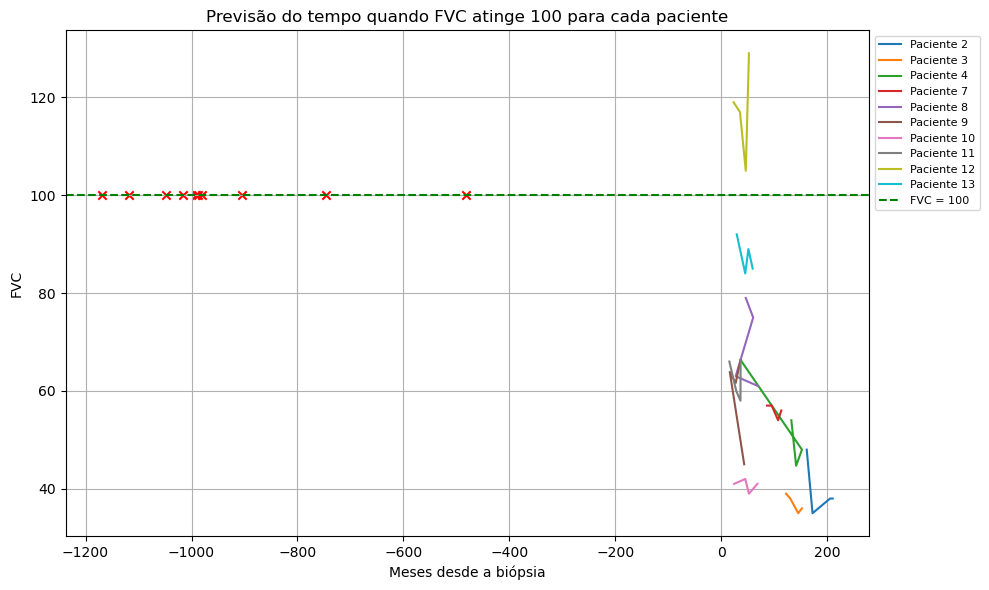

In [108]:
# Criando o gráfico para visualizar melhor os dados 
plt.figure(figsize=(10, 6))
pacientes_exibidos = treino_resultados['PACIENTE'].unique()[:10]
for PACIENTE in pacientes_exibidos:
    paciente_data = treino_resultados[treino_resultados['PACIENTE'] == PACIENTE]
    plt.plot(paciente_data['MESES'], paciente_data['FVC'], label=f'Paciente {PACIENTE}')
    tempo_fvc_100 = paciente_data['tempo_fvc_100'].iloc[0]
    if not np.isnan(tempo_fvc_100):
        plt.scatter(tempo_fvc_100, 100, color='red', marker='x')  # Marca o ponto onde FVC atinge 100

plt.axhline(100, color='green', linestyle='--', label='FVC = 100')
plt.xlabel('Meses desde a biópsia')
plt.ylabel('FVC')
plt.title('Previsão do tempo quando FVC atinge 100 para cada paciente')
plt.legend(loc='upper left', fontsize=8, bbox_to_anchor=(1, 1))  # Coloca a legenda à direita
plt.grid(True)
plt.tight_layout()
plt.show()